In [19]:
import math 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from pmdarima.arima import auto_arima, ADFTest
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from utilities import *


import warnings
warnings.filterwarnings('ignore')

### Cargar los datasets

In [20]:
df_delitos, df_camaras = load_data()
df_delitos = vinculate_incidentes_camaras(df_delitos, df_camaras)

Cargando ../data/C5_Delitos.pkl
Cargando ../data/C5_Camaras.pkl
Cargando ../data/C5_Delitos-Camaras.pkl


### Filtros

In [21]:
SECTORES_INCLUIR = ['MORELOS', 'CONGRESO', 'ALAMEDA', 'CENTRO']
INCIDENTES_EXCLUIR = ['Disturbio-Escándalo', 'Disturbio-Riña']	# Se consideran el resto y Administrativas-Ebrios

# Filtrar df_delitos por el sector_inicio
df_delitos = df_delitos[df_delitos['sector_inicio'].isin(SECTORES_INCLUIR)]# Morelos, Congreso, Alameda y Centro En un solo archivo incluyendo una columna del sector /// Sin roma

# Filtrar df_delitos por el año 2022
df_delitos = df_delitos[df_delitos['fecha_creacion'].dt.year == 2022]

# Filtrar df_delitos excluyendo los incidentes_c4 que se encuentren en la lista de incidentes_c4 a excluir
df_delitos = df_delitos[~df_delitos['incidente_c4'].isin(INCIDENTES_EXCLUIR)]

# La metodologia de los datos, como codigos de cierre, fechas  utilizadas
# Meter metodologia del algoritmo utilizada
# Resultados obtenidos
# Siguientes pasos (Conjuncion de camaras, gfrupos horarios, etc	)

# Eliminar las columnas [latitud, longitud, folio, incidente_c4] de df_delitos porque generan conflicto al momento de agrupar por fecha y hora
columns = list(df_delitos.columns)
columns = [x for x in columns if x not in ['latitud', 'longitud', 'folio', 'incidente_c4', 'colonia', 'sector_inicio', 'delegacion_inicio']]


# Cuenta el número de ocurrencias de cada delito
incidentes_c4_frecuencia = df_delitos['incidente_c4'].value_counts().sort_values(ascending=False)
print(f'Cantidad de registros por incidente_c4: \n[{len(df_delitos["incidente_c4"])}] 100%\n{(incidentes_c4_frecuencia/incidentes_c4_frecuencia.sum()*100).apply(lambda x: f"{x:.2f}%")}')


Cantidad de registros por incidente_c4: 
[11411] 100%
Administrativas-Ebrios                           35.02%
Administrativas-Drogados                         26.48%
Robo-Transeúnte                                  13.23%
Administrativas-Franeleros                       10.80%
Robo-Establecimiento sin Violencia                3.42%
Robo-Vehículo sin Violencia                       2.02%
Administrativas-Tirar Basura en Vía Pública       1.99%
Robo-Auto partes                                  1.56%
Administrativas-Comercio Informal                 1.50%
Robo-Automovilista                                1.44%
Robo-Establecimiento con Violencia                1.12%
Administrativas-Grafitis                          0.81%
Robo-Bienes Gubernamentales (Coladeras Cable)     0.33%
Robo-Cable                                        0.28%
Name: incidente_c4, dtype: object


### Último Preprocesamiento

Most common crime:  Agresión-Persona


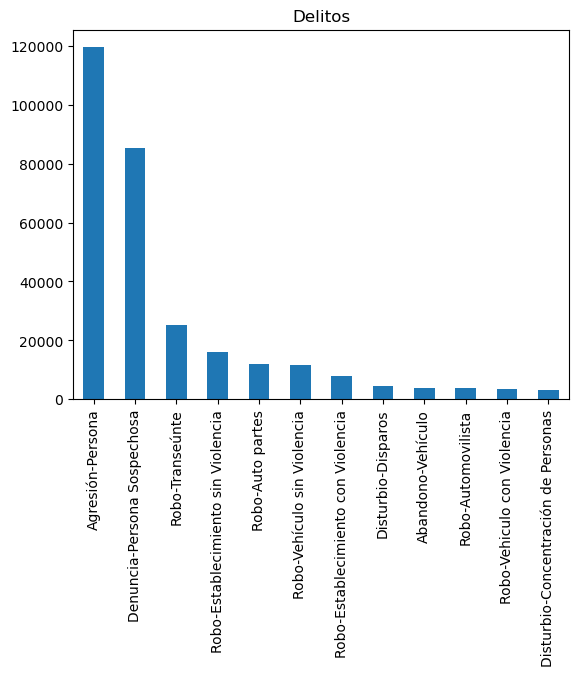

In [22]:
# Asignar 00 a los minutos y segundos de la hora en la columna fecha_creacion y convertir a datetime
df_delitos['fecha_creacion'] = df_delitos['fecha_creacion'].dt.strftime('%Y-%m-%d %H:00:00')
df_delitos['fecha_creacion'] = pd.to_datetime(df_delitos['fecha_creacion'], format='%Y-%m-%d %H:%M:%S')

### Revision de tabla a procesar

In [5]:
df_delitos = df_delitos.groupby('id_camara')
df_delitos.head()

,folio,incidente_c4,fecha_creacion,sector_inicio,delegacion_inicio,colonia,latitud,longitud,id_camara
0,C2C/20220112/00030,Administrativas-Drogados,2022-01-12 08:00:00,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435283,-99.147152,1
1,C5/20220118/00090,Robo-Transeúnte,2022-01-18 00:00:00,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435149,-99.147325,1
4,C2C/20220202/00008,Administrativas-Ebrios,2022-02-02 01:00:00,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435283,-99.147152,1
5,C2C/20220215/00113,Administrativas-Ebrios,2022-02-15 16:00:00,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435283,-99.147152,1
6,C5/20220214/03490,Administrativas-Ebrios,2022-02-14 21:00:00,ALAMEDA,CUAUHTEMOC,CENTRO (AREA 5),19.435824,-99.146737,1
...,...,...,...,...,...,...,...,...,...
31958,C5/20220113/02836,Robo-Automovilista,2022-01-13 19:00:00,CONGRESO,VENUSTIANO CARRANZA,AMPLIACION PENITENCIARIA,19.435420,-99.115640,17290
31969,C5/20220520/05386,Robo-Automovilista,2022-05-20 19:00:00,CONGRESO,VENUSTIANO CARRANZA,AMPLIACION PENITENCIARIA,19.435270,-99.116450,17290
31970,C2N/20220614/00137,Robo-Transeúnte,2022-06-14 19:00:00,CONGRESO,VENUSTIANO CARRANZA,AMPLIACION PENITENCIARIA,19.435700,-99.116500,17290
31975,C2N/20220902/00049,Robo-Transeúnte,2022-09-02 10:00:00,CONGRESO,VENUSTIANO CARRANZA,AMPLIACION PENITENCIARIA,19.435700,-99.116500,17290


In [10]:
# Análisis estádistico utilizando auto ARIMA

# save the minumum error and best error 
min_value = math.inf
max_value = -math.inf
dayofweek = {0: 'lunes', 1: 'martes', 2: 'miercoles', 3: 'jueves', 4: 'viernes', 5: 'sabado', 6: 'domingo'}

# Total
totaliterations = len(df_delitos.groups) * 24 * 7

# Start timer to measure the time of execution
tS = time()
ts_day, te_day = tS, tS
ts_hour, te_hour = tS, tS
ts_camara, te_camara = tS, tS

meantime_camara, meancount_camara = 0, 0
meantime_hour, meancount_hour = 0, 0
meantime_day, meancount_day = 0, 0

# Save whole results in only one excel called 'Consigas_total.csv' with the columns: STV:id_camara, hora:hour_start:00-hour_start:59, dia:dayofweek
df_delitos_count_total = pd.DataFrame(columns=['STV', 'hora', 'dia', 'sector'])
df_delitos_count_total_raw = pd.DataFrame(columns=['STV', 'hora', 'dia', 'sector'])

# Start timer to measure the time of execution
start = time.time()
start_day = start
end_day = start
start_camara = start
end_camara = start

# Iteration for each hour and day of the week
# for day in range(0, 7):
for day in range(6,-1,-1):
    # dictionary with the day of the week in spanish
    # day name in spanish
    day_name = dayofweek[day]
    # Save next results where there is data for the day of the week in a excel called 'consigas_[dayofweek].csv' with the columns: STV:id_camara, hora:hour_start:00-hour_start:59, dia:dayofweek
    # create a dataframe with the columns: STV:id_camara, hora:hour_start:00-hour_start:59, dia:dayofweek
    ### df_delitos_count_day = pd.DataFrame(columns=['STV', 'hora', 'dia', 'sector'])
    ### df_delitos_count_day_raw = pd.DataFrame(columns=['STV', 'hora', 'dia', 'sector'])
    # Start time for each day of the week
    meantime_day += round((te_day - ts_day), 2)
    timeday_log = f'<{day_name} [{seconds_to_time(meantime_day/(meancount_day | 1))} per day]'
    meancount_day += 1
    ts_day = time()
    # for hour in range(0, 24):
    for hour in range(23, -1, -1):
        # Start time for each hour
        meantime_hour += round((te_hour - ts_hour), 2)
        timehour_log = f'<{hour}:00 [{seconds_to_time(meantime_hour/(meancount_hour | 1))} per hour]'
        meancount_hour += 1
        ts_hour = time()
        i = 0
        for id_camara, df in df_delitos:
            i += 1
            meantime_camara += round((te_camara - ts_camara), 2)
            timecamara_log = f'<{id_camara} ({i}/{len(df_delitos.groups)}) [{seconds_to_time(meantime_camara/(meancount_camara | 1))} per camera]'
            meancount_camara += 1
            # stimated time to finish using the mean time of each camera and the total number of cameras and total of iterations
            stimated_time = seconds_to_time(round((meantime_camara/(meancount_camara | 1)) * (totaliterations - meancount_camara),2))
            print(f'\r[{seconds_to_time(round((te_camara - tS), 2))} total / {stimated_time} to finish] {timecamara_log} {timehour_log} {timeday_log}\t\t\t\t', end='\r')
            # Start time for each camera
            ts_camara = time()
            # sector_inicio
            sector = df['sector_inicio'].iloc[0]
            # Count the number of crimes per day but saving the date and the id_camara and set the fecha_creacion as index
            df_delitos_count = df.groupby(columns).size().reset_index(name='count')
            # Create rows for all the hours in the year 2022 and 2023 without losing the existing data
            df_delitos_count = df_delitos_count.set_index('fecha_creacion').reindex(pd.date_range(start='2022-01-01', end='2023-02-01', freq='H')).reset_index().rename(columns={'index': 'fecha_creacion'})
            # Find not nat values
            df_delitos_count.fillna(0, inplace=True)
            # Split the data into train (last 3 months in 2022) and test (first 2 weeks in 2023)
            # DONT USE 'train = df_delitos_count[df_delitos_count.fecha_creacion.dt.year == 2022 and df_delitos_count.fecha_creacion.dt.month >= 10]' IS AMBIGUOUS
            train = df_delitos_count[(df_delitos_count.fecha_creacion.dt.year == 2022) | (df_delitos_count.fecha_creacion.dt.isocalendar().week >= 52)]
            test = df_delitos_count[(df_delitos_count.fecha_creacion.dt.year == 2023) & (df_delitos_count.fecha_creacion.dt.isocalendar().week == 1)]
            # Hacer autoarima como en la seccion de abajo para todos los lunes a las 00:00, despues todos los lunes a las 01:00, etc
            # Filter the data for the hour and day of the week
            train_hour = train[(train.fecha_creacion.dt.hour == hour) & (train.fecha_creacion.dt.dayofweek == day)]
            test_hour = test[(test.fecha_creacion.dt.hour == hour) & (test.fecha_creacion.dt.dayofweek == day)]
            # If there is no data for the hour and day of the week, continue
            if len(train_hour) == 0:# or len(test_hour) == 0:
                continue
            # Fit the model
            model = auto_arima(train_hour['count'], stationary=True,
                                    test='adf', start_p=1, d=1, start_q=0,
                                    max_p=7, max_d=7, max_q=7,
                                    # daily data
                                    m=0,
                                    # Desactivar el test
                                    # seasonal=False,
                                    seasonal=False,
                                    seasonal_test='ch', start_P=0, D=0, start_Q=0,
                                    trace=False, stepwise=True,
                                    suppress_warnings=True, error_action='ignore',
                                    random_state=0)
            # Forecast
            forecast, confint = model.predict(n_periods=len(test_hour), return_conf_int=True)
            # day as string name
            # Save the results from the forecast
            ### df_delitos_count_day = pd.concat([df_delitos_count_day, pd.DataFrame({'STV': id_camara, 'hora': f'{hour:02d}:00-{hour:02d}:59', 'dia': day_name, 'cantidad': forecast, 'sector':sector})], ignore_index=True)
            ### df_delitos_count_day_raw = pd.concat([df_delitos_count_day, pd.DataFrame({'STV': id_camara, 'hora': f'{hour:02d}:00-{hour:02d}:59', 'dia': day_name, 'cantidad': forecast, 'sector':sector})], ignore_index=True)
			# Save the results from the forecast
            df_delitos_count_total = pd.concat([df_delitos_count_total, pd.DataFrame({'STV': id_camara, 'hora': f'{hour:02d}:00-{hour:02d}:59', 'dia': day_name, 'cantidad': forecast, 'sector':sector})], ignore_index=True)
            df_delitos_count_total_raw = pd.concat([df_delitos_count_total, pd.DataFrame({'STV': id_camara, 'hora': f'{hour:02d}:00-{hour:02d}:59', 'dia': day_name, 'cantidad': forecast, 'sector':sector})], ignore_index=True)
            # End time for each camera
            te_camara = time()
        # End time for each hour
        te_hour = time()
    #Drop rows tih cantidad = 0
    ### df_delitos_count_day = df_delitos_count_day[df_delitos_count_day['cantidad'] != 0]
    # Order the columns by dia, hora and STV
    ### df_delitos_count_day.sort_values(by=['dia', 'hora', 'STV'], inplace=True)
    ### df_delitos_count_day_raw.sort_values(by=['dia', 'hora', 'STV'], inplace=True)
    # Save the results from the forecast
    ### df_delitos_count_day.to_csv(f'{DATA_PATH}consigas_CENTRO_{day_name}.csv', index=False)
    ### df_delitos_count_day_raw.to_csv(f'{DATA_PATH}consigas_CENTRO_{day_name}_raw.csv', index=False)
    # End time for each day of the week
    te_day = time()

# End time for the whole script
end = time()
print(f'\nDone! [{seconds_to_time(round((end - tS), 2))}s total]')

# Round values to 0 if they are less than 0.01 to floor else ceil
df_delitos_count_total['cantidad'] = df_delitos_count_total['cantidad'].apply(lambda x: math.floor(x) if x-int(x) < 0.01 else math.ceil(x)).apply(lambda x: 0 if x<0 else x)

# Order the columns by dia, hora and STV
df_delitos_count_total.sort_values(by=['dia', 'hora', 'STV'], inplace=True)
df_delitos_count_total_raw.sort_values(by=['dia', 'hora', 'STV'], inplace=True)
# Save the results from the forecast
df_delitos_count_total.to_csv(f'{DATA_PATH}consigas_C2CENTRO.csv', index=False)
df_delitos_count_total_raw.to_csv(f'{DATA_PATH}consigas_C2CENTRO.raw.csv', index=False)

SyntaxError: unexpected character after line continuation character (935039905.py, line 119)

In [24]:
df_delitos['sector_inicio'].value_counts()

CENTRO      5182
ALAMEDA     3416
MORELOS     2178
CONGRESO     635
Name: sector_inicio, dtype: int64

In [18]:
df_camaras['sector'].value_counts()

CENTRO      146
ALAMEDA     134
CONGRESO    102
MORELOS      64
Name: sector, dtype: int64

In [36]:

for sector in df_camaras['sector'].unique():
	print(f"\n\n***** {sector} *****")
	print(df_delitos[df_delitos['sector_inicio']==sector]['incidente_c4'].value_counts())
	



***** ALAMEDA *****
Administrativas-Ebrios                           1019
Administrativas-Drogados                          959
Robo-Transeúnte                                   534
Robo-Establecimiento sin Violencia                266
Administrativas-Franeleros                        247
Robo-Automovilista                                 68
Administrativas-Comercio Informal                  66
Robo-Auto partes                                   58
Robo-Vehículo sin Violencia                        55
Robo-Establecimiento con Violencia                 48
Administrativas-Grafitis                           45
Administrativas-Tirar Basura en Vía Pública        33
Robo-Bienes Gubernamentales (Coladeras Cable)      16
Robo-Cable                                          2
Name: incidente_c4, dtype: int64


***** CENTRO *****
Administrativas-Ebrios                           1815
Administrativas-Drogados                         1540
Administrativas-Franeleros                        686
Robo-T

## Cambiado de umbral

In [7]:
dayofweek = {0: 'lunes', 1: 'martes', 2: 'miércoles', 3: 'jueves', 4: 'viernes', 5: 'sábado', 6: 'domingo'}

for day in range(6,-1,-1):
	day_name = dayofweek[day]
	df_delitos_count_day_raw = pd.read_csv(f'{DATA_PATH}consigas_{day_name}_raw.csv')
	print(f'Cantidad de delitos en {day_name}: {df_delitos_count_day_raw.shape[0]}')

	# Copia de df_delitos_count_day_raw
	df_delitos_count_day = df_delitos_count_day_raw.copy()
	# Redondear hacia arriba si la columna cantidad es arriba de 0.01 de lo contrario redondear hacia abajo
	df_delitos_count_day['cantidad'] = df_delitos_count_day['cantidad'].apply(lambda x: math.ceil(x) if x > 0.01 else math.floor(x))
	# Eliminar filas con cantidad = 0
	df_delitos_count_day = df_delitos_count_day[df_delitos_count_day['cantidad'] != 0]
	# Guardar archivo
	df_delitos_count_day.to_csv(f'{DATA_PATH}consigas_{day_name}_0.01.csv', index=False)

	

FileNotFoundError: [Errno 2] No such file or directory: '../data/consigas_domingo_raw.csv'

In [ ]:
df_delitos_count_day_raw